In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1rc_3n91So-S-zyoRh3JD9SoeJoU15TbM" -O "fra.txt"

--2020-11-06 06:41:42--  https://drive.google.com/uc?export=download&id=1rc_3n91So-S-zyoRh3JD9SoeJoU15TbM
Resolving drive.google.com (drive.google.com)... 74.125.142.139, 74.125.142.100, 74.125.142.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grsv18tjeeijfrdppdaad9vrf3ta1ii2/1604644875000/13472183013488020071/*/1rc_3n91So-S-zyoRh3JD9SoeJoU15TbM?e=download [following]
--2020-11-06 06:41:42--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grsv18tjeeijfrdppdaad9vrf3ta1ii2/1604644875000/13472183013488020071/*/1rc_3n91So-S-zyoRh3JD9SoeJoU15TbM?e=download
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-94-docs.googleusercontent.com (doc-14

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

In [ ]:
batch_size = 64      # 학습 배치 사이즈.
epochs = 100         # 학습하고자 하는 에폭 사이즈.
latent_dim = 256     # 인코더 디코더 LSTM 모델의 unit 사이즈.
num_samples = 10000  # 입력 데이터의 최대 sequence.
# 프랑스-영어 병렬 코퍼스 파일 경로.
data_path = 'fra.txt'

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # "tab"을 목표 데이터의 시작, 종료 문자로 지정
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [ ]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # 디코더의 목표 데이터는 디코더 입력 데이터 보다 한 step 만큼 앞서 있음
            # 또한 디코더의 목표 데이터는 시작 문자(tab) 이 존재하지 않음
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, name='encoder')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 인코더의 결과 값 중 맥락벡터(h, c) 만 디코더 모델로 전달
encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# 디코더의 상태값(h, c)값을 매 스텝마다 리턴 받도록 설정
# 학습시에는 상태값을 사용하지 않지만 예측 시에 사용
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder')
# 인코더에서 계산 된 맥락벡터(h, c)를 디코더의 첫번째 은닉층의 상태값으로 사용
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

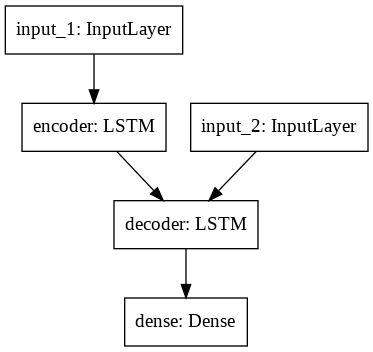

In [ ]:
from keras.utils import plot_model

plot_model(model)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 2s 17ms/step - loss: 0.9163 - accuracy: 0.0652 - val_loss: 0.9505 - val_accuracy: 0.0947
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.7346 - accuracy: 0.1143 - val_loss: 0.7674 - val_accuracy: 0.1358
Epoch 3/100
125/125 [==============================] - 2s 13ms/step - loss: 0.6210 - accuracy: 0.1388 - val_loss: 0.6782 - val_accuracy: 0.1571
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5632 - accuracy: 0.1534 - val_loss: 0.6366 - val_accuracy: 0.1681
Epoch 5/100
125/125 [==============================] - 2s 13ms/step - loss: 0.5233 - accuracy: 0.1644 - val_loss: 0.5969 - val_accuracy: 0.1809
Epoch 6/100
125/125 [==============================] - 2s 13ms/step - loss: 0.4924 - accuracy: 0.1727 - val_loss: 0.5723 - val_accuracy: 0.1876
Epoch 7/100
125/125 [==============================] - 2s 13ms/step - loss: 0.4667 - accuracy: 0.1798 - val_loss: 0.5482 - val_accuracy:

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # 인코더 모델에 입력 데이터를 넣어 상태값(h, c)을 계산
    states_value = encoder_model.predict(input_seq)

    # 디코더 모델에서 이전 스텝의 결과를 다음 스텝에 넣어주기 위한 변수 생성
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # 디코더 모델에 최초 스텝에 입력되는 시작 문자(Tab) 설정
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # 디코더에 의해 계산된 문자별 확률값에서 가장 높은 값의 인덱스를 가져옴
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 반복문의 종료 조건 체크(스텝의 학습데이터의 최대 사이즈를 넘어가는지
        # , 종료 문자(Tab) 발생하는지)
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 디코더의 다음 스텝에 입력데이터로 사용할 문자값을 계산된 값으로 업데이트
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 디코더의 다음 스텝에 사용할 상테값을 계산된 값으로 업데이트
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça ausez !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: Hello!
Deco

KeyboardInterrupt: ignored